# Usage

An Experiment should have:

    1. Baseline - FULL_0
    2. FULL_attack_ratio
    3. MID_attack_ratio
    4. END_attack_ratio

Place all these in a folder and call ```plot_results()``` method with ```path, model name and attack ratio``` 

# Plot Code 

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import statistics


def plot_2d(title: str, graph_type: str, baseline: list, full: list, mid: list, end: list, save_dir:str=None):
    plt.title(title)
    rounds = [i for i in range(len(baseline))]
    plt.plot(rounds, baseline, label="Baseline")
    plt.plot(rounds, full, label="FULL")
    plt.plot(rounds, mid, label="MID")
    plt.plot(rounds, end, label="END")
    plt.xlabel("Federated Learning Rounds")
    plt.ylabel(graph_type)
    plt.legend()
    plt.show()


def plot_3d(title: str, graph_type: str, baseline: list, full: list, mid: list, end: list, save_dir:str=None):
    # Assuming you have data in the following format:
    # rounds: List of federated learning rounds
    # baseline_accuracy: List of baseline accuracy values
    # full_100_accuracy: List of accuracy values for FULL attack with 100% label flipping
    # mid_50_accuracy: List of accuracy values for MID attack with 50% label flipping
    # end_30_accuracy: List of accuracy values for END attack with 30% label flipping

#     plt.clf()
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    rounds = [i for i in range(len(baseline))]

    # Plot baseline accuracy
    ax.plot(rounds, [0] * len(rounds), baseline,
            label='Baseline', color='blue', linewidth=2)

    # Plot FULL attack with 100% label flipping
    ax.plot(rounds, [1] * len(rounds), full,
            label='FULL', color='green', linewidth=2)

    # Plot MID attack with 50% label flipping
    ax.plot(rounds, [2] * len(rounds), mid,
            label='MID', color='red', linewidth=2)

    # Plot END attack with 30% label flipping
    ax.plot(rounds, [3] * len(rounds), end,
            label='END', color='purple', linewidth=2)

    # Set labels
    ax.set_xlabel('Federated Learning Rounds')
    # ax.set_ylabel('Label Flipping Intensity')
    ax.set_zlabel(graph_type, rotation=90)
    ax.set_yticks([0, 1, 2, 3])
    # ax.set_yticklabels(['Baseline', 'FULL', 'MID', 'END'])
    ax.set_title(title)

    # Adjust layout to make room for the z-axis label
    ax.set_box_aspect(aspect=None, zoom=0.8)

    # Add legend
    ax.legend()
    plt.tight_layout()
    # Show the 3D plot
    if save_dir: 
        plt.savefig(save_dir+title+graph_type+".png", bbox_inches='tight')
    plt.show()
    



def plot_other_metrics(title: str, metrics_centralized: dict, save_dir: str=None):
    num_classes = len(metrics_centralized["precision"])
    precision_list = [metrics_centralized["precision"][i][1]
                      for i in range(num_classes)]
    recall_list = [metrics_centralized["recall"][i][1]
                   for i in range(num_classes)]
    f1_list = [metrics_centralized["f1"][i][1] for i in range(num_classes)]

    print(title, "Precision", round(statistics.mean(precision_list),2),"Recall", round(statistics.mean(recall_list),2),"F1", round(statistics.mean(f1_list),2))

    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    plt.suptitle(title)

    # Precision
    # plt.subplot(131)
    axs[0, 0].bar(range(num_classes), precision_list, color='blue')
    axs[0, 0].set_xlabel('FL Round')
    axs[0, 0].set_ylabel('Precision')
    axs[0, 0].set_title('Precision')

    # Recall 
    # plt.subplot(132)
    axs[0, 1].bar(range(num_classes), recall_list, color='green')
    axs[0, 1].set_xlabel('FL Round')
    axs[0, 1].set_ylabel('Recall')
    axs[0, 1].set_title('Recall')

    # F1
    # plt.subplot(133)
    axs[1, 0].bar(range(num_classes), f1_list, color='orange')
    axs[1, 0].set_xlabel('FL Round')
    axs[1, 0].set_ylabel('F1-Score')
    axs[1, 0].set_title('F1-Score')


    # plt.subplot(1)
    sns.heatmap(metrics_centralized['confusion_matrix'][-1][1],
                fmt="d", cmap="Blues", annot=True,
                xticklabels=range(num_classes),
                yticklabels=range(num_classes), ax=axs[1,1])
    axs[1, 1].set_title("Confusion Matrix")
    axs[1, 1].set_xlabel("Predicted")
    axs[1, 1].set_ylabel("True")

    plt.tight_layout()
    if save_dir: 
        plt.savefig(save_dir+title+"-metrics.png")
    plt.show()
   



def plot_results(dir: str, model: str, attack_ratio: int, plot_mode: str = '3d', save_dir:str=None):
    title_dict = {"MLP": "Multi Layer Perceptron",
                  "SCNN": "Simple Convolution Neural Network",
                  "LGR": "Logistic Regression", 
                  "LSVC": "SVC - Linear Kernel",
                  "XGB": "XGBoost",
                  "RF": "Random Forest",
                  "LSTM": "LSTM",
                  "RNN": "RNN"}

    plot_method = None
    if plot_mode == '2d':
        plot_method = plot_2d
    elif plot_mode == '3d':
        plot_method = plot_3d

    title = title_dict[model] + " - " + \
        str(attack_ratio) + "%" + " Adverserial Clients"

    # Baseline 
    file = open(dir + model + "_FULL_0.pkl", 'rb')
    baseline_result = pickle.load(file)
    file.close()
    baseline_loss = baseline_result['history'].losses_centralized
    baseline_accuracy = baseline_result['history'].metrics_centralized['accuracy']
    plot_other_metrics(model + " Baseline - No Adverserial Clients", baseline_result['history'].metrics_centralized, save_dir)

    # Temporal - FULL 
    file = open(dir + model + "_FULL_" +
                str(attack_ratio) + ".pkl", 'rb')
    full_mal = pickle.load(file)
    file.close()
    full_mal_loss = full_mal['history'].losses_centralized
    full_mal_accuracy = full_mal['history'].metrics_centralized['accuracy']
    plot_other_metrics(title + " (Full)", full_mal['history'].metrics_centralized, save_dir)

    # Temporal - MID
    file = open(dir + model + "_MID_" +
                str(attack_ratio) + ".pkl", 'rb')
    mid_mal = pickle.load(file)
    file.close()
    mid_mal_loss = mid_mal['history'].losses_centralized
    mid_mal_accuracy = mid_mal['history'].metrics_centralized['accuracy']
    plot_other_metrics(title + " (MID)", mid_mal['history'].metrics_centralized, save_dir)

    # Temporal - END 
    file = open(dir + model + "_END_" +
                str(attack_ratio) + ".pkl", 'rb')
    end_mal = pickle.load(file)
    file.close()
    end_mal_loss = end_mal['history'].losses_centralized
    end_mal_accuracy = end_mal['history'].metrics_centralized['accuracy']
    plot_other_metrics(title + " (END)", end_mal['history'].metrics_centralized, save_dir)

    baseline_loss_list = [baseline_loss[i][1]
                          for i in range(len(baseline_loss))]
    full_mal_loss_list = [full_mal_loss[i][1]
                          for i in range(len(full_mal_loss))]
    mid_mal_loss_list = [mid_mal_loss[i][1] for i in range(len(mid_mal_loss))]
    end_mal_loss_list = [end_mal_loss[i][1] for i in range(len(end_mal_loss))]

    plot_method(title, "Loss", baseline_loss_list, full_mal_loss_list,
                mid_mal_loss_list, end_mal_loss_list, save_dir)

    baseline_accuracy_list = [baseline_accuracy[i][1]
                              for i in range(len(baseline_accuracy))]
    full_mal_accuracy_list = [full_mal_accuracy[i][1]
                              for i in range(len(full_mal_accuracy))]
    mid_mal_accuracy_list = [mid_mal_accuracy[i][1]
                             for i in range(len(mid_mal_accuracy))]
    end_mal_accuracy_list = [end_mal_accuracy[i][1]
                             for i in range(len(end_mal_accuracy))]
    
    print("baseline", "Loss", round(baseline_loss_list[-1],2))
    print(model, str(attack_ratio), "FULL", "Loss", round(full_mal_loss_list[-1],2))
    print(model, str(attack_ratio), "MID", "Loss", round(mid_mal_loss_list[-1],2))
    print(model, str(attack_ratio), "END", "Loss", round(end_mal_loss_list[-1],2))

    print("baseline", "Accuracy", round(baseline_accuracy_list[-1],2))
    print(model, str(attack_ratio), "FULL", "Accuracy", round(full_mal_accuracy_list[-1],2))
    print(model, str(attack_ratio), "MID", "Accuracy", round(mid_mal_accuracy_list[-1],2))
    print(model, str(attack_ratio), "END", "Accuracy", round(end_mal_accuracy_list[-1],2))
    
    
    plot_method(title, "Accuracy", baseline_accuracy_list,
                full_mal_accuracy_list, mid_mal_accuracy_list, end_mal_accuracy_list, save_dir)


# Label Shifting

## Multi Layer Perceptron

MLP Baseline - No Adverserial Clients Precision 0.84 Recall 0.83 F1 0.83


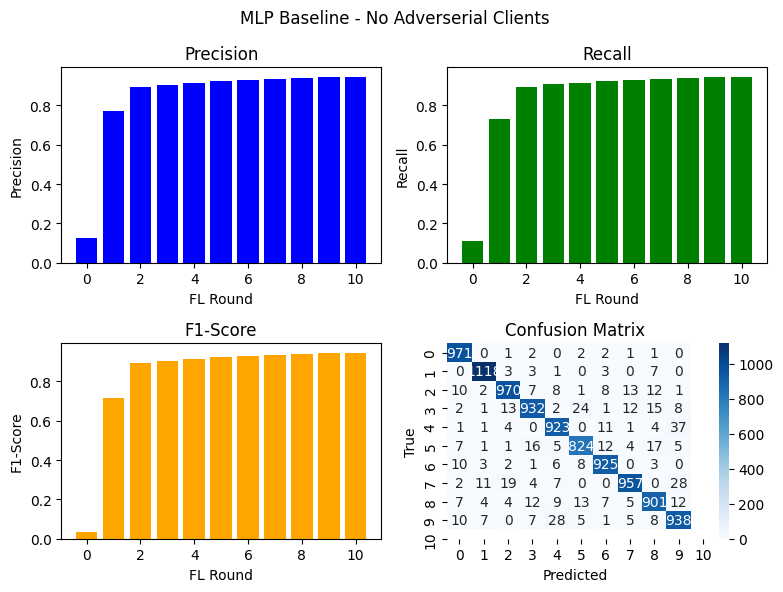

Multi Layer Perceptron - 25% Adverserial Clients (Full) Precision 0.81 Recall 0.81 F1 0.8


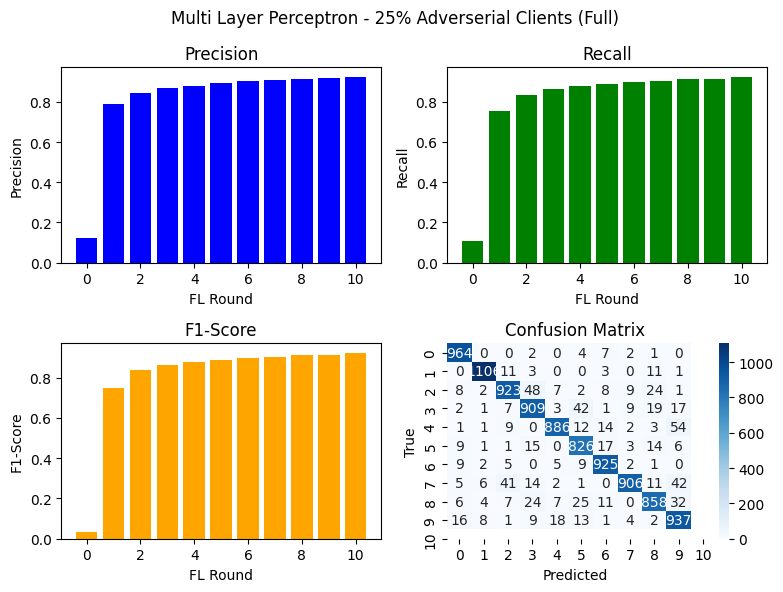

Multi Layer Perceptron - 25% Adverserial Clients (MID) Precision 0.83 Recall 0.82 F1 0.81


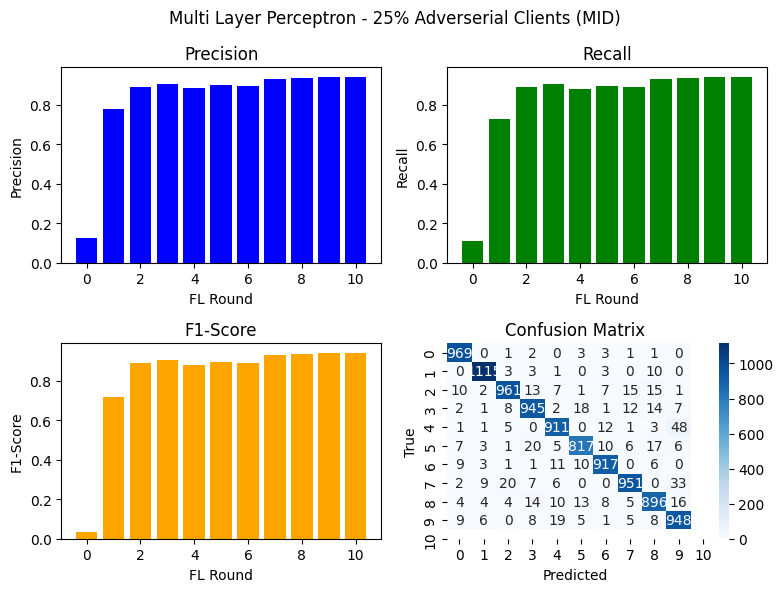

Multi Layer Perceptron - 25% Adverserial Clients (END) Precision 0.83 Recall 0.83 F1 0.82


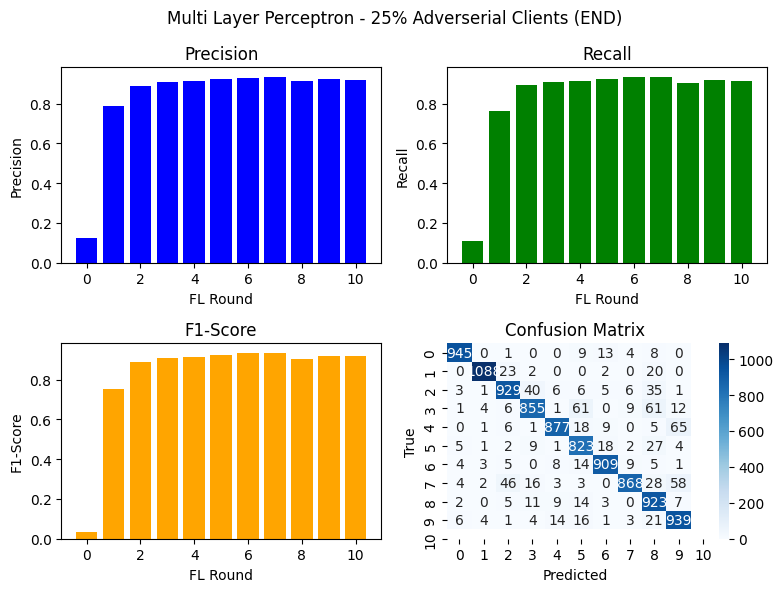

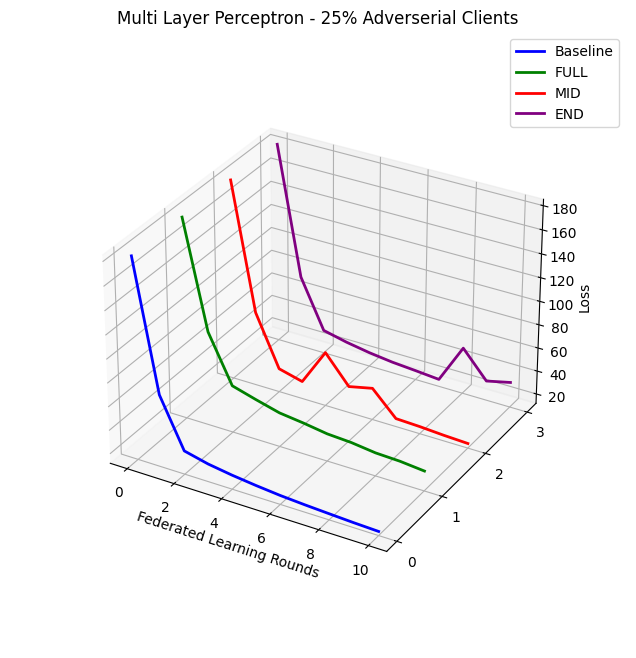

baseline Loss 15.27
MLP 25 FULL Loss 28.75
MLP 25 MID Loss 15.78
MLP 25 END Loss 33.28
baseline Accuracy 0.95
MLP 25 FULL Accuracy 0.92
MLP 25 MID Accuracy 0.94
MLP 25 END Accuracy 0.92


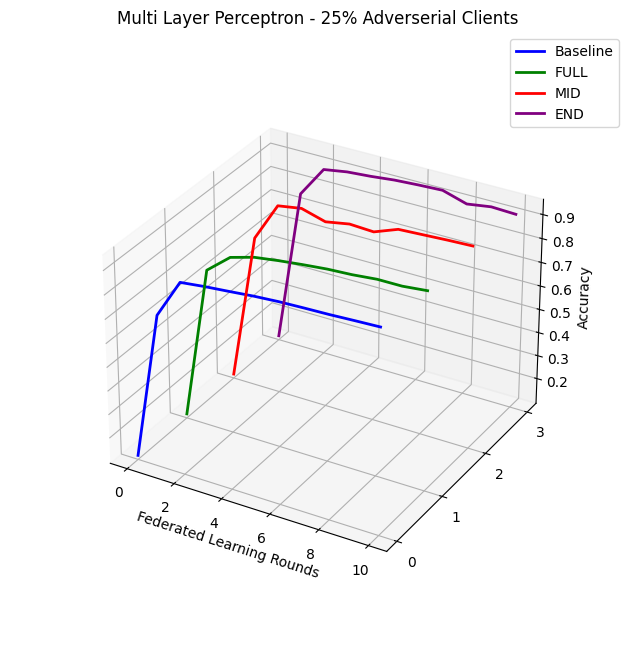

In [10]:
plot_results("runs0/LF/", "MLP", 25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## Simple CNN

In [ ]:
plot_results("runs0/LF/", "SCNN", 25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## Logistic Regression

In [ ]:
plot_results("runs0/LF/", "LGR", 25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## Linear SVM 

In [ ]:
plot_results("runs0/LF/", "LSVC", 25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## XGBoost

In [ ]:
plot_results("runs0/LF/", "XGB", 25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## RF

In [ ]:
plot_results("runs0/LF/", "RF", 25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## LSTM 


In [ ]:
plot_results("runs0/LF/", "LSTM", 25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## RNN

In [ ]:
plot_results("runs0/LF/", "RNN", 25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

# GAN attack 

# MPAF attack 

## Simple CNN 

In [ ]:
plot_results(dir="runs0/MPAF/", model="SCNN", attack_ratio=25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## Multi Layer Perceptron 

In [ ]:
plot_results(dir="runs0/MPAF/", model="MLP", attack_ratio=25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## Logistic Regression 

In [ ]:
plot_results(dir="runs0/MPAF/", model="LGR", attack_ratio=25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## Linear SVC 

In [ ]:
plot_results(dir="runs0/MPAF/", model="LSVC", attack_ratio=25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## XGBoost

In [ ]:
plot_results(dir="runs0/MPAF/", model="XGB", attack_ratio=25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## RF

In [ ]:
plot_results(dir="runs0/MPAF/", model="RF", attack_ratio=25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## LSTM

In [ ]:
plot_results(dir="runs0/MPAF/", model="LSTM", attack_ratio=25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## RNN

RNN Baseline - No Adverserial Clients Precision 0.8 Recall 0.8 F1 0.79


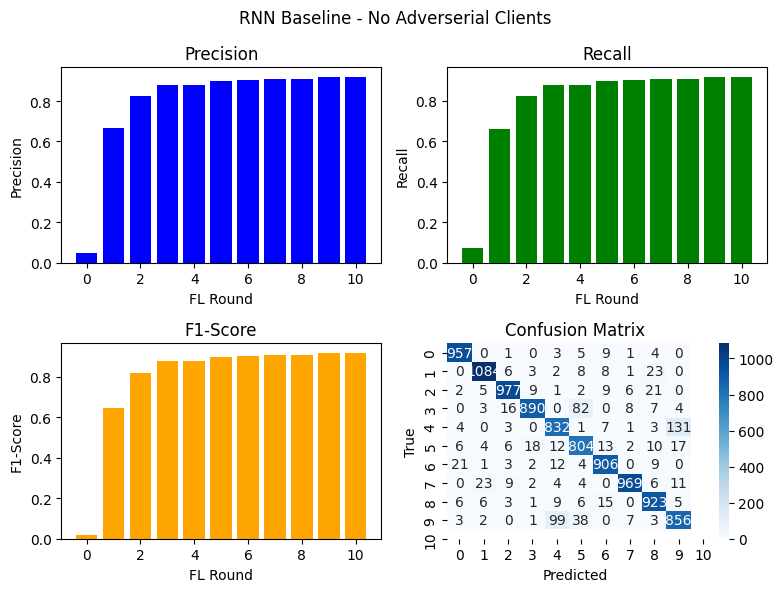

RNN - 25% Adverserial Clients (Full) Precision 0.13 Recall 0.12 F1 0.07


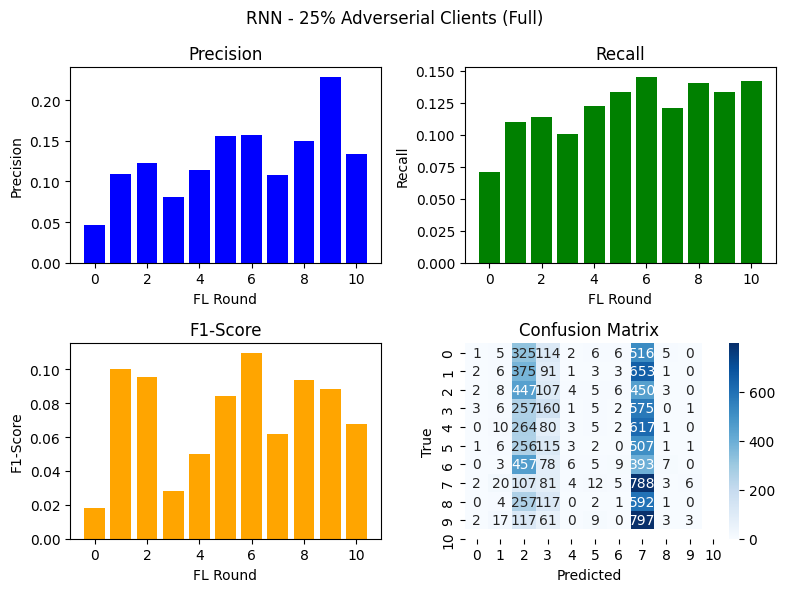

RNN - 25% Adverserial Clients (MID) Precision 0.31 Recall 0.31 F1 0.29


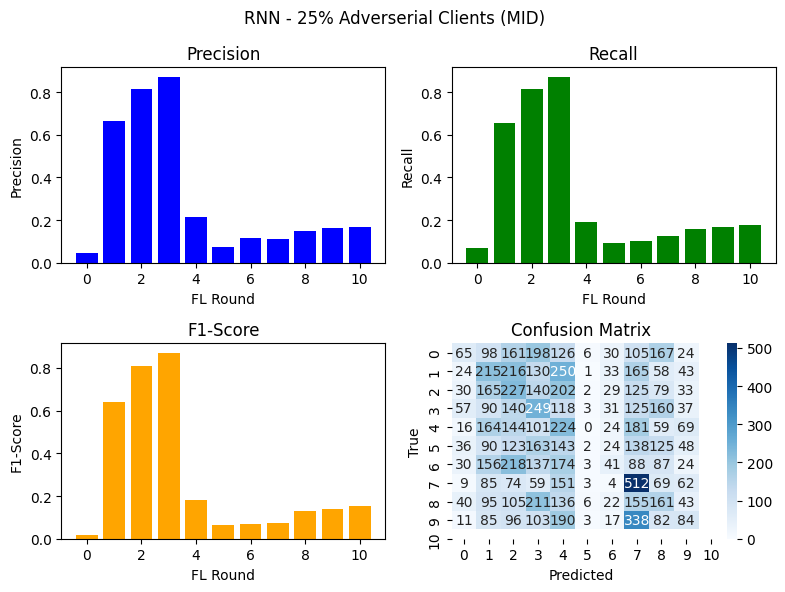

RNN - 25% Adverserial Clients (END) Precision 0.59 Recall 0.59 F1 0.59


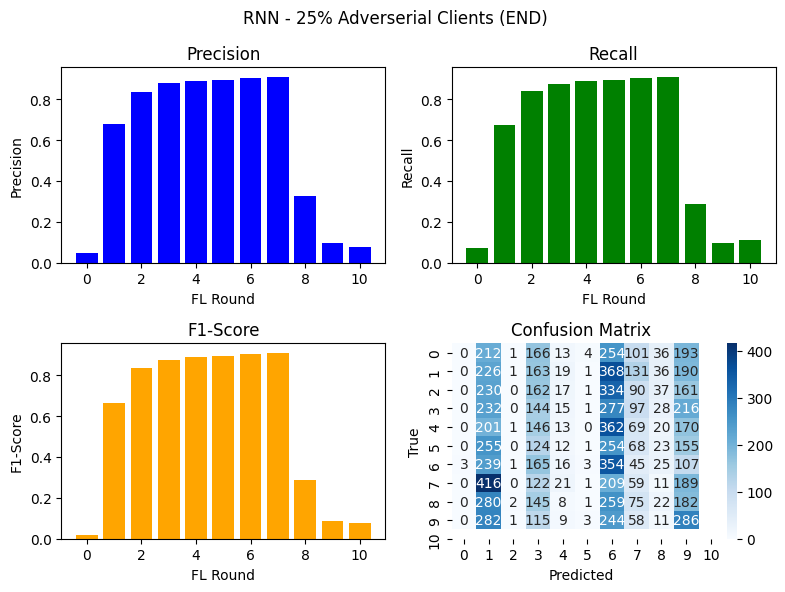

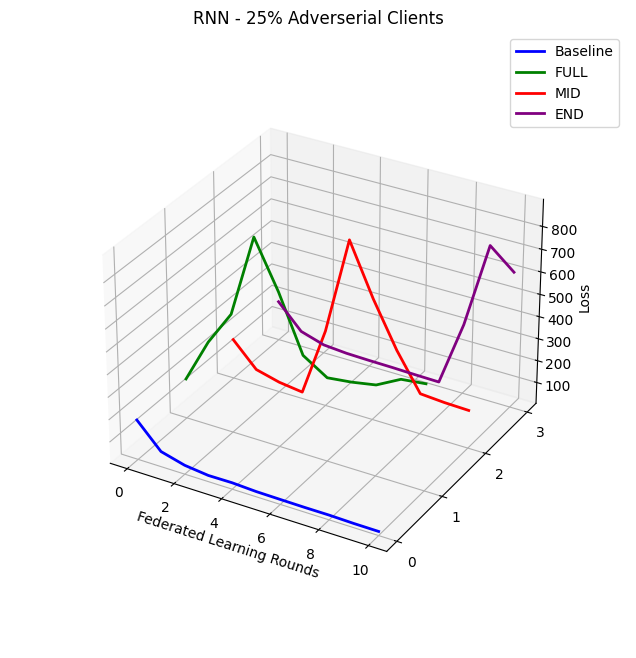

baseline Loss 22.3
RNN 25 FULL Loss 478.64
RNN 25 MID Loss 175.1
RNN 25 END Loss 614.25
baseline Accuracy 0.92
RNN 25 FULL Accuracy 0.14
RNN 25 MID Accuracy 0.18
RNN 25 END Accuracy 0.11


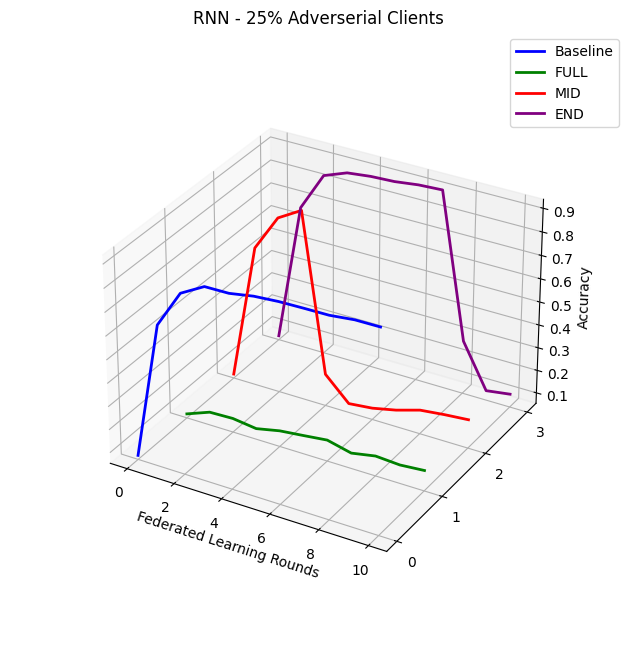

In [9]:
plot_results(dir="runs0/MPAF/", model="RNN", attack_ratio=25, save_dir="C:/Users/rohit/Documents/workspace/CS 297/298 Report/images/results/")

## Simple CNN 